In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path

results_dir = Path(r"E:\\CODE\\trishift\\artifacts\\results\\adamson")
split_id = 1
pkl_path = results_dir / f"trishift_adamson_{split_id}.pkl"
if not pkl_path.exists():
    raise FileNotFoundError(f"missing {pkl_path} (run prediction export first)")
with open(pkl_path, 'rb') as f:
    trishift_df = pickle.load(f)

available_conditions = sorted(trishift_df.keys())
print('n conditions', len(available_conditions))
print('examples', available_conditions[:10])


n conditions 17
examples ['ATP5B+ctrl', 'BHLHE40+ctrl', 'CARS+ctrl', 'CCND3+ctrl', 'COPB1+ctrl', 'DERL2+ctrl', 'HARS+ctrl', 'HYOU1+ctrl', 'MANF+ctrl', 'MRPL39+ctrl']


In [ ]:
gene_plot = 'BHLHE40'
cond_key = f"{gene_plot}+ctrl" if f"{gene_plot}+ctrl" in trishift_df else gene_plot
if cond_key not in trishift_df:
    cond_key = available_conditions[0]
    gene_plot = cond_key.replace('+ctrl', '')
    print(f'condition not found, fallback to {cond_key}')

entry = trishift_df[cond_key]
de_name = entry.get('DE_name')
if de_name is None:
    raise KeyError('DE_name not found in result dict')

trishift_ctrl = pd.DataFrame(entry['Ctrl'], columns=de_name)
trishift_true = pd.DataFrame(entry['Truth'], columns=de_name)
trishift_pred = pd.DataFrame(entry['Pred'], columns=de_name)

true_delta = (trishift_true - trishift_ctrl.median()).assign(Group='True')
pred_delta = (trishift_pred - trishift_ctrl.median()).assign(Group='TriShift')
merge = pd.concat([true_delta, pred_delta])
df_melted = merge.melt(id_vars='Group', var_name='Gene', value_name='Expression')
df_melted['Group'] = pd.Categorical(df_melted['Group'], categories=['True', 'TriShift'], ordered=True)
gene_order = list(df_melted[df_melted.Group=='True'].drop(['Group'],axis=1).groupby('Gene').median().sort_values(by='Expression', ascending=False).index)
df_melted['Gene'] = pd.Categorical(df_melted['Gene'], categories=gene_order, ordered=True)

custom_palette = {
    'True': '#868686FF',
    'TriShift': '#EFC000FF'
}


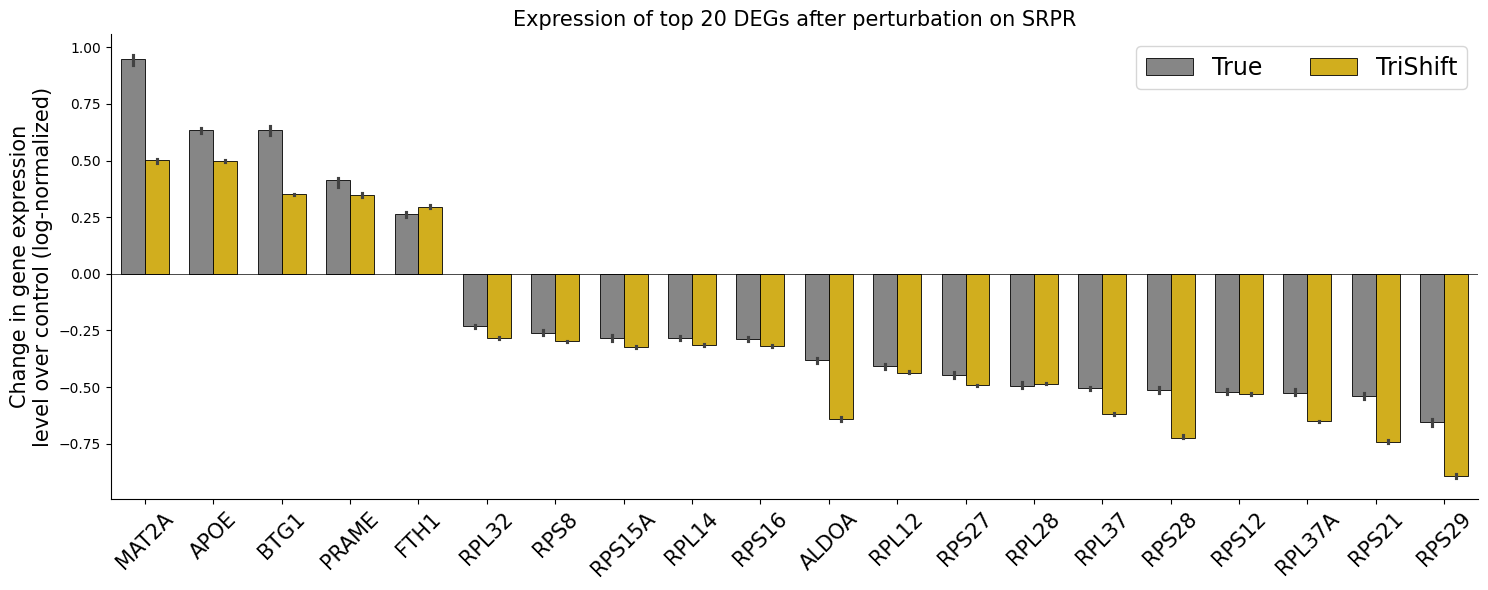

In [5]:
plt.figure(figsize=(15, 6), dpi=100)
ax = sns.barplot(
    data=df_melted,
    x='Gene',
    y='Expression',
    hue='Group',
    width=0.7,
    palette=custom_palette,
    estimator='median',
    errorbar=('ci', 50),
)
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.6)
plt.legend(loc='upper right', ncol=2, fontsize=17)
plt.xticks(rotation=45, fontsize=15)
plt.title(f'Expression of top 20 DEGs after perturbation on {gene_plot}', fontsize=15)
plt.xlabel('')
plt.ylabel('Change in gene expression\nlevel over control (log-normalized)', fontsize=15)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
plt.show()
